## Figure 2 - Time Series Observations: Earthquake, GPS, InSAR

In [1]:
%matplotlib inline
import os
import numpy as np
from datetime import timedelta, datetime as dt
from matplotlib import pyplot as plt, ticker, dates as mdates
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12, 'xtick.major.pad': 6})

from mintpy.objects import gps
from mintpy.utils import ptime, readfile, utils as ut, plot as pp

proj_dir = os.path.expanduser('~/Papers/2021_Kirishima/figs_src')
work_dir = os.path.join(proj_dir, 'obs')
os.chdir(work_dir)
print('Go to directory', work_dir)

## Points of Interest
lalo_list = [
    # Shinmoe-dake
    [31.9131, 130.8867],  # point A for AlosDT73  - eastern rim
    [31.9113, 130.8774],  # point B for Alos2DT23 - western rim
    # Iwo-yama
    #[31.9467, 130.8524], # POI     for Alos2AT131 -crater
    [31.9465, 130.8531],  # point C for Alos2DT23 - crater
    [31.9450, 130.8528],  # point S for Alos2DT23 - southern vent
    [31.9467, 130.8506],  # point W for Alos2DT23 - western vent
]
ref_lalo_Iwo = [31.9315, 130.8733]

Go to directory /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs


### Read time-series data

In [2]:
## Number of EQs
num_eq_file = os.path.join(proj_dir, 'data/num_earthquake.csv')
fc = np.loadtxt(num_eq_file, delimiter=',', dtype=bytes).astype(str)
eq_dates = np.array([dt.strptime(i, '%Y-%m') for i in fc[:,0]])
# read number of EQs around Shinmoe-dake and Iwo-yama into eq_num_list
eq_num_list = []
for i in range(1, fc.shape[1]):
    eq_num = fc[:,i]
    eq_num[eq_num == ''] = '0'
    eq_num = eq_num.astype(np.float32)
    eq_num[eq_num == 0] = np.nan
    eq_num_list.append(eq_num)


## GPS baseline change
gps_dir = os.path.expanduser('~/data/Kirishima/GPS/GSI_F3')
t0, t1 = '20070101', '20191001'
site1, sites = '950486', '960714'
dates1, x1, y1, z1 = gps.read_GSI_F3(gps_dir, '950486', t0, t1)
dates2, x2, y2, z2 = gps.read_GSI_F3(gps_dir, '960714', t0, t1)
gps_dates, gps_lens = gps.get_baseline_change(dates1, x1, y1, z1, dates2, x2, y2, z2)
## start from zero
#idx = gps_dates.index(dt(2005, 12, 15, 12, 0))
#gps_lens -= gps_lens[idx]

### Utilities Functions

In [3]:
## Utilities function for point time-series
def read_point_displacement_timeseries(ts_file, pts_lalo, ref_lalo=None):
    dates, dis_ts = ut.read_timeseries_lalo(pts_lalo[0], pts_lalo[1], ts_file, unit='cm', print_msg=False)
    if ref_lalo:
        dis_ts -= ut.read_timeseries_lalo(ref_lalo[0], ref_lalo[1], ts_file, unit='cm', print_msg=False)[1]
    dis_ts -= dis_ts[0]
    ex_date_txt = os.path.join(os.path.dirname(ts_file), 'exclude_date.txt')
    ex_dates = ptime.date_list2vector(ptime.read_date_list(ex_date_txt))[0]
    idx_ex = [dates.tolist().index(di) for di in dates if di in ex_dates]
    idx_kp = [dates.tolist().index(di) for di in dates if di not in ex_dates]
    return dis_ts, dates, idx_kp, idx_ex

def plot_point_displacement_timeseries(ax, ts_file, pts_lalo, ref_lalo=None, offset=0, marker='^', color='k', label=None):
    if marker == '^':
        ms = 3
    else:
        ms = 2.5
    dis_ts, dates, idx_kp, idx_ex = read_point_displacement_timeseries(ts_file, pts_lalo, ref_lalo=ref_lalo)
    ax.scatter(dates[idx_ex], dis_ts[idx_ex] + offset, marker=marker, edgecolor=color, facecolors='none', s=ms**3, linewidths=0.5)
    ax.scatter(dates[idx_kp], dis_ts[idx_kp] + offset, marker=marker, edgecolor=color, facecolors=color,  s=ms**3, linewidths=0.5, label=label)
    pp.auto_adjust_xaxis_date(ax, dates, every_year=1, buffer_year=0.3)
    return ax

def plot_date_of_interest(axs, y1max=1, y2min=0):
    """Plot the date(s) of interest for Kirishima volcano"""
    kwargs = dict(zorder=0, clip_on=False, alpha=0.3)

    # Phreatic eruptions in Shinmoe-dake
    kwargs.update(linestyle='-', color='C0')
    axs[0].axvline(x   =dt(2008, 8, 22),                       ymax=y1max, linewidth=2, **kwargs)
    axs[0].axvspan(xmin=dt(2010, 3, 31), xmax=dt(2010, 7, 10), ymax=y1max, linewidth=0, **kwargs)

    # Magmatic eruptions in Shinmoe-dake
    kwargs.update(linestyle='-', color='C1')
    axs[1].axvline(x   =dt(2017, 10, 11),                       ymax=y1max, linewidth=2, **kwargs)
    axs[0].axvspan(xmin=dt(2011, 1 , 19), xmax=dt(2011, 9, 7 ), ymax=y1max, linewidth=0, **kwargs)
    axs[1].axvspan(xmin=dt(2018, 3 , 1 ), xmax=dt(2018, 6, 27), ymax=y1max, linewidth=0, **kwargs)

    # Phreatic eruptions in Iwo-yama
    kwargs.update(linestyle='--', color='C0', alpha=0.8)
    axs[1].axvline(x=dt(2018, 4, 19), ymin=y2min, linewidth=2, **kwargs)
    return


def cut_along_xaxis(axs, figsize=[7, 1], width_ratio=[4, 5], ax2s=None):
    """Cut and hide part of the plot along x-axis"""
    axs[0].set_xlim(dt(2007, 9,  7), dt(2011,  9, 7))   # 4 years
    axs[1].set_xlim(dt(2014, 11, 5), dt(2019, 11, 5))  # 5 years

    # hide the spines between two axis
    axs[0].spines['right'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[0].yaxis.tick_left()
    if ax2s is None:
        axs[1].yaxis.tick_right()

    # hide the spines between two axis for ax2
    if ax2s is not None:
        ax2s[0].set_yticks([])
        ax2s[0].spines['right'].set_visible(False)
        ax2s[1].spines['left'].set_visible(False)
        # turn off yticks on the right
        #axs[1].yaxis.tick_left()

    # plot diagonal lines in axes coordinates
    dx = 0.008
    dy = dx * figsize[0] / figsize[1]
    kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
    axs[0].plot((1-dx, 1+dx), ( -dy,  +dy), **kwargs)
    axs[0].plot((1-dx, 1+dx), (1-dy, 1+dy), **kwargs)

    dx *= (width_ratio[0] / width_ratio[1])
    kwargs.update(transform=axs[1].transAxes)
    axs[1].plot(( -dx,  +dx), ( -dy,  +dy), **kwargs)
    axs[1].plot(( -dx,  +dx), (1-dy, 1+dy), **kwargs)
    return

width_ratio = [4, 5]
print('Utilities functions initiated.')

Utilities functions initiated.


### **a.** Number of earthquakes

save figure to file /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs/ts_eq.png


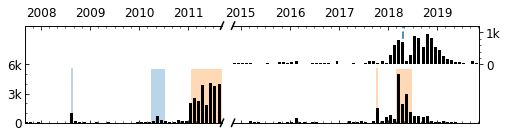

In [4]:
figsize = [7, 1.5]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios': width_ratio})
ax2s = []
for ax in axs:
    #shift half a month to display the monthly average value in the center.
    ax.bar(eq_dates + timedelta(days=15), eq_num_list[0]/1000., width=22, color='k')
    ax.set_ylim(0, 10)

    ax2 = ax.twinx()
    ax2.bar(eq_dates + timedelta(days=15), eq_num_list[1]/1000., width=22, color='k')
    ax2.set_ylim(-1.8, 1.2)
    ax2s.append(ax2)

# Eruptive dates
plot_date_of_interest(axs, y1max=0.55, y2min=0.65)

# axes format
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    #ax.set_xticklabels([])
    ax.xaxis.tick_top()
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=False, right=False)

ax = axs[0]
ax.tick_params(left=True,  right=False)
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.linspace(0,6,7)))
ax.yaxis.set_major_locator(ticker.FixedLocator([0,3,6]))
ax.set_yticklabels(['0', '3k', '6k'])
ax = ax2s[1]
ax.tick_params(left=False, right=True)
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.linspace(0,1,6)))
ax.yaxis.set_major_locator(ticker.FixedLocator([0,1]))
ax.set_yticklabels(['0', '1k'])
fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Cut along x-axis
cut_along_xaxis(axs, figsize=figsize, ax2s=ax2s)

# output
out_file = os.path.abspath('ts_eq.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=600)
print('save figure to file', out_file)
plt.show()

### **b**. GPS baseline change

save figure to file /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs/ts_gps.png


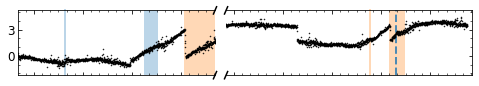

In [5]:
figsize = [7, 1]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios': width_ratio})
for ax in axs:
    ax.scatter(gps_dates, gps_lens*100., marker='.', color='k', s=1**2)

# Eruptive dates
plot_date_of_interest(axs)

# axes format
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([])
    ax.set_ylim(-2.2, 5.2)
fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Cut along x-axis
cut_along_xaxis(axs, figsize=figsize)

# output
out_file = os.path.abspath('ts_gps.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=600)
print('save figure to file', out_file)
plt.show()

### **f.** InSAR LOS displacement

save figure to file /Users/yunjunz/Papers/2021_Kirishima/figs_src/obs/ts_insar.png


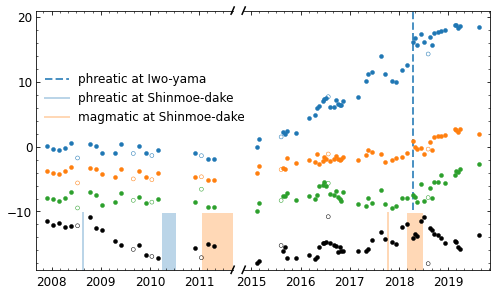

In [6]:
## Shinmoe-dake
ts_file1 = os.path.expanduser('~/data/Kirishima/KirishimaAlosDT73/mintpyAll/timeseries_ERA5_ramp_demErr.h5')
ts_file2 = os.path.expanduser('~/data/Kirishima/KirishimaAlos2DT23/mintpyAll/timeseries_ERA5_ramp_demErr.h5')

figsize = [7, 4]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios': width_ratio})
#------ Displacement time-series
marker = 'o'
for ax in axs:
    # Iwo-yama crater: C
    plot_point_displacement_timeseries(ax, ts_file1, lalo_list[2], marker=marker, color='C0', ref_lalo=ref_lalo_Iwo, offset=0)   # Iwo-yama crater C
    plot_point_displacement_timeseries(ax, ts_file2, lalo_list[2], marker=marker, color='C0', ref_lalo=ref_lalo_Iwo, offset=0)   # Iwo-yama crater C
    plot_point_displacement_timeseries(ax, ts_file1, lalo_list[3], marker=marker, color='C1', ref_lalo=ref_lalo_Iwo, offset=-4)   # Iwo-yama vent S
    plot_point_displacement_timeseries(ax, ts_file2, lalo_list[3], marker=marker, color='C1', ref_lalo=ref_lalo_Iwo, offset=-4)   # Iwo-yama vent S
    plot_point_displacement_timeseries(ax, ts_file1, lalo_list[4], marker=marker, color='C2', ref_lalo=ref_lalo_Iwo, offset=-8)   # Iwo-yama vent W
    plot_point_displacement_timeseries(ax, ts_file2, lalo_list[4], marker=marker, color='C2', ref_lalo=ref_lalo_Iwo, offset=-10)   # Iwo-yama vent W
    plot_point_displacement_timeseries(ax, ts_file1, lalo_list[0], marker=marker, color='k', offset=-13)   # Shinmoe-dake A
    plot_point_displacement_timeseries(ax, ts_file2, lalo_list[1], marker=marker, color='k', offset=-18)   # Shinmoe-dake B

#------ Eruptive dates
plot_date_of_interest(axs, y1max=0.22, y2min=0.23)

# legend
lines = [Line2D([0], [0], lw=2, linestyle='--', color='C0', alpha=0.8),
         Line2D([0], [0], lw=2, linestyle='-',  color='C0', alpha=0.3),
         Line2D([0], [0], lw=2, linestyle='-',  color='C1', alpha=0.3),]
labels = ['phreatic at Iwo-yama', 'phreatic at Shinmoe-dake', 'magmatic at Shinmoe-dake']
axs[0].legend(lines, labels, frameon=False, loc='upper left', bbox_to_anchor=(-0.01, 0.80))

#------- axes format
for ax in axs:
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)
    ax.set_ylim([-19, 21])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

#----- Cut along x-axis
cut_along_xaxis(axs, figsize=figsize)

#----- output
out_file = os.path.abspath('ts_insar.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=600)
print('save figure to file', out_file)
plt.show()